# TUTORIAL: Real-time data assimilation in a chaotic system - Lorenz63
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>


* [The Ensemble Kalman filter (recap)](#enKF)
* [Test case: twin experiment on the Lorenz63 model](#twin)
    * [The true state and parameters](#truth)
    * [The observations](#obs)
    * [The ensemble](#ens)
    * [Data assimilation](#da)

## The Ensemble Kalman filter <a class="anchor" id="enKF"></a>

As explained in tutorials 00-01, real-time data assimilation updates our knowledge in the model state $\boldsymbol{\phi}$ and the parameters $\boldsymbol{\alpha}$ when observation data of the modelled physical quantity become available. To perform state and parameter estimation, we introduced the augmented state vector $\boldsymbol{\psi}=[\boldsymbol{\phi};\boldsymbol{\alpha};\mathbf{q}]$, such that
$$
\begin{align}
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\psi} &=& \mathbf{F}\left(\boldsymbol{\psi} +\boldsymbol{\epsilon}_\psi\right){\mathrm{d} t}  \\
\mathbf{q} &=& \mathbf{M}\mathbf{\psi}  + \boldsymbol{\epsilon}_{q}
\end{array}
\right.
\end{align}
$$ where $\mathbf{F}$ and $\boldsymbol{\epsilon}_\psi$ are the augmented nonlinear operator and aleatoric uncertainties, respectively; $\mathbf{M} = \left[\mathbf{0}~\big|~\mathbb{I}_{N_q}\right]$ is the linear measurement operator.

We take a stochastic ensemble data assimilation approach to tackle nonlinear dynamics. Algorithmically, 
1. we forecast in time $m$-realizations of the augmented state to obtain an ensemble of forecast states $\boldsymbol{\psi}_j^\text{f}$; 
2. when data $\mathbf{d}$ become available, we use real-time data assimilation (e.g., the ensemble Kalman filter (EnKF)) to statistically combine the data with the forecast ensemble, which yields the analysis ensemble $\boldsymbol{\psi}_j^\mathrm{a}$; 
3. we re-initialize the model with the analysis ensemble to perform the next analysis step. 

</p>


In [1]:

import numpy as np
from scipy import linalg
rng = np.random.default_rng(0)

def EnKF(Af, observations, C_dd, M):
    """ 
        Inputs:
            Af: ensemble forecast as a class object
            observations: observation at time t
            C_dd: observation error covariance matrix
            M: measurement operator matrix
        Returns:
            Aa: analysis ensemble 
    """
    
    m = Af.shape[-1]
    psi_f_m = np.mean(Af, 1, keepdims=True)     # ensemble mean
    Psi_f = Af - psi_f_m                        # deviations from the mean
    
    # Create an ensemble of observations
    D = rng.multivariate_normal(observations, C_dd, m).transpose()
    
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.dot(M, Af)
    S = np.dot(M, Psi_f)
    
    C = (m - 1) * Cdd + np.dot(S, S.T)  # Kalman gain matrix
    X = np.dot(S.T, np.dot(linalg.inv(C), (D - Y)))

    return Af + np.dot(Af, X)



## Test case: twin experiment on the Lorenz63 model <a class="anchor" id="twin"></a>


In real scenarios, we do not have access to the truth, and thus we do not know which are the optimal state and parameters which estimate the system under investigation. In this tutorial, we investigate the EnKF with a twin experiment, which consist of generating a synthetic true state from the same numerical model as the forecast, and then create the observations by adding stochastic uncertainty to the synthetic truth. This is, we compute the truth $\mathbf{d}^\dagger$ as 
$$
\begin{equation}
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\psi^\dagger } &=& \mathbf{F}\left(\boldsymbol{\psi}^\dagger\right){\mathrm{d} t}  \\
\mathbf{d}^\dagger &=& \mathbf{M}\mathbf{\psi}^\dagger
\end{array}
\right.
\end{equation}
$$
and the observations as  $\mathbf{d} = \mathbf{d}^\dagger +  \boldsymbol{\epsilon}_d$. During the assimilation we assume that we do not know the true state and parameters $\mathbf{\psi}^\dagger$, and our objective is to recover them. 

We investigate the Lorenz63 model consists of the system of ordinary differential equations 
$$
\begin{align}
\left\{
\begin{array}{rcl}
\frac{\mathrm{d}x}{\mathrm{d}t} &= &\sigma (y - x) \\
\frac{\mathrm{d}y}{\mathrm{d}t} &= &x (\rho - z) - y \\
\frac{\mathrm{d}z}{\mathrm{d}t} &= &x y - \beta z.
\end{array}\right.
\end{align}
$$

In the state-space formulation introduced above, we have the state variables $\boldsymbol{\phi}=[x;y;x]$, the model parameters  $\boldsymbol{\alpha}=[\sigma;\rho;\beta]$ and the operator $\mathbf{F}$ is the right hand side of the equations. In this problem, we assume that the observables are the state variables. 
 
### Chaotic dynamics in data assimilation

The Lorenz63 model exhibits chaotic dynamics at certain combinations of parameters. Chaotic systems make data assimilation challenging because their predictability horizon is short due to the butterfly effect. For instance, at $\boldsymbol{\alpha}=[10; 28; 8/3]$ two solutions initialized with 0.01\% difference evolve as 

<img src="figs/Lorenz/Lorenz_butterfly.gif" width="750" align="center">

The predictability horizon in chaotic systems is given by the Lyapunov time, i.e., the time for the distance between two nearby trajectories in the phase space increases by a factor of e. The Lyapunov time is th inverse of the maximal Lyapunov exponent. For the Lorenz system, the maximal Lyapunov exponent is known to be about 0.9056. 



### 1) The truth and observations <a class="anchor" id="truth"></a> 



In [2]:

from essentials.models_physical import Lorenz63
from essentials.create import create_truth

# True parameters
alpha_true = dict(rho=28.,
                   sigma=10.,
                   beta=8. / 3.,)
dt_t = 0.015
observe_dims=[0, 1, 2]     # Select the dimensions to observe


t_lyap = 0.9056 ** (-1)  # Lyapunov Time (inverse of maximal Lyapunov exponent)


dt_obs = t_lyap * 1.1  # time between analyses


truth = create_truth(Lorenz63, 
                     dt=dt_t,
                     psi0=rng.random(3)+10,
                     observe_dims=observe_dims,     
                     std_obs=0.02,
                     Nt_obs = dt_obs // dt_t, 
                     t_start = t_lyap * 10,
                     t_stop = t_lyap * 60 , 
                     **alpha_true
                     )

d_obs, t_obs = truth['y_obs'], truth['t_obs']



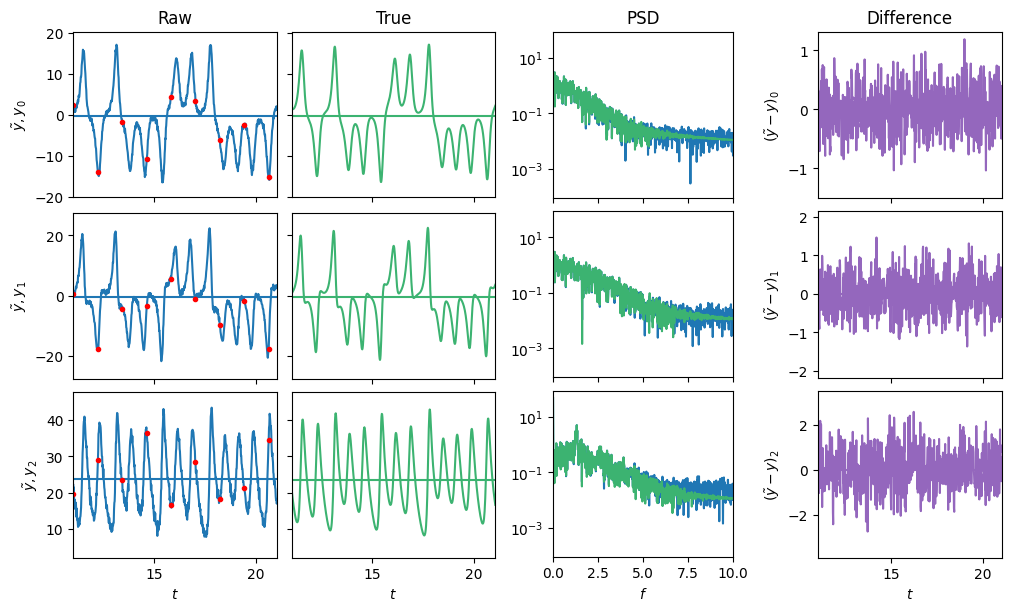

In [3]:
# Visualize the truth and observations
from essentials.plotResults import plot_truth
plot_truth(**truth, f_max=10, window=10)

### 2) Define the forecast ensemble  <a class="anchor" id="ens"></a>
We create an ensemble with randomly generated states and parameters

In [4]:
from essentials.create import create_ensemble

# alpha_true = dict(rho=28.,
#                    sigma=10.,
#                    beta=8. / 3.,)
alpha0 = dict(rho=(25., 35.),
              beta=(2, 4),
              sigma=(5,15))

forecast_params = dict(model=Lorenz63,      
                       dt=dt_t,             
                       m=50,               # Number of ensemble members
                       std_psi=0.2,        # Initial uncertainty in the state
                       std_a=alpha0,       # Initial uncertainty in the parameters
                       sigma=10.,
                       beta=8. / 3.,
                       observe_dims=observe_dims
                       )

ensemble = create_ensemble(**forecast_params)


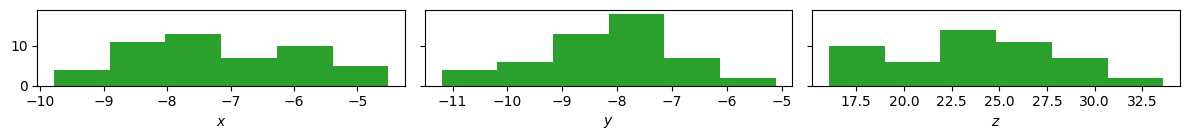

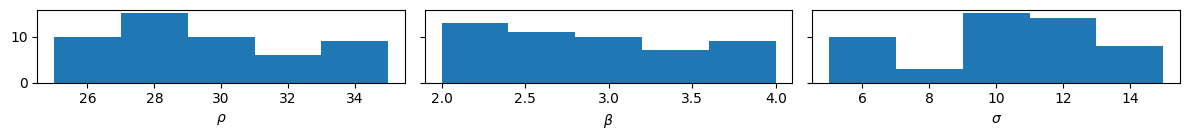

In [5]:
# Visualize ensemble initialization
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble)

### 4) Apply data assimilation <a class="anchor" id="da"></a>
We now have all the ingredients to start our data assimilation algorithm.

In [17]:

filter_ens = ensemble.copy()

# Define measurement error covariance matrix
std_d = 0.05 * np.max(abs(np.mean(filter_ens.get_observable_hist(), axis=-1)), axis=0)  

Cdd = np.diag(std_d ** 2)

    
# ----------------------------------------------------------------------------
for d, t_d in zip(d_obs, t_obs):
    # Parallel forecast to next observation
    Nt = int(np.round((t_d - filter_ens.get_current_time) / filter_ens.dt))
    psi, t = filter_ens.time_integrate(Nt)
    filter_ens.update_history(psi, t)
    # Perform assimilation 
    Af = np.vstack((filter_ens.get_current_state, 
                    filter_ens.get_observables()))    # augmented state matrix [phi; alpha; q] x m
    
    Aa = EnKF(Af, d, Cdd, filter_ens.M) 
    # Update the initial condition for the next forecast
    filter_ens.update_history(Aa[:-filter_ens.Nq, :], update_last_state=True)
# ----------------------------------------------------------------------------

#Forecast the ensemble further without assimilation
Nt_extra = int(4 * t_lyap / filter_ens.dt) 

psi, t = filter_ens.time_integrate(Nt_extra, averaged=False)
filter_ens.update_history(psi, t)

filter_ens.close() # closes the parallel pools


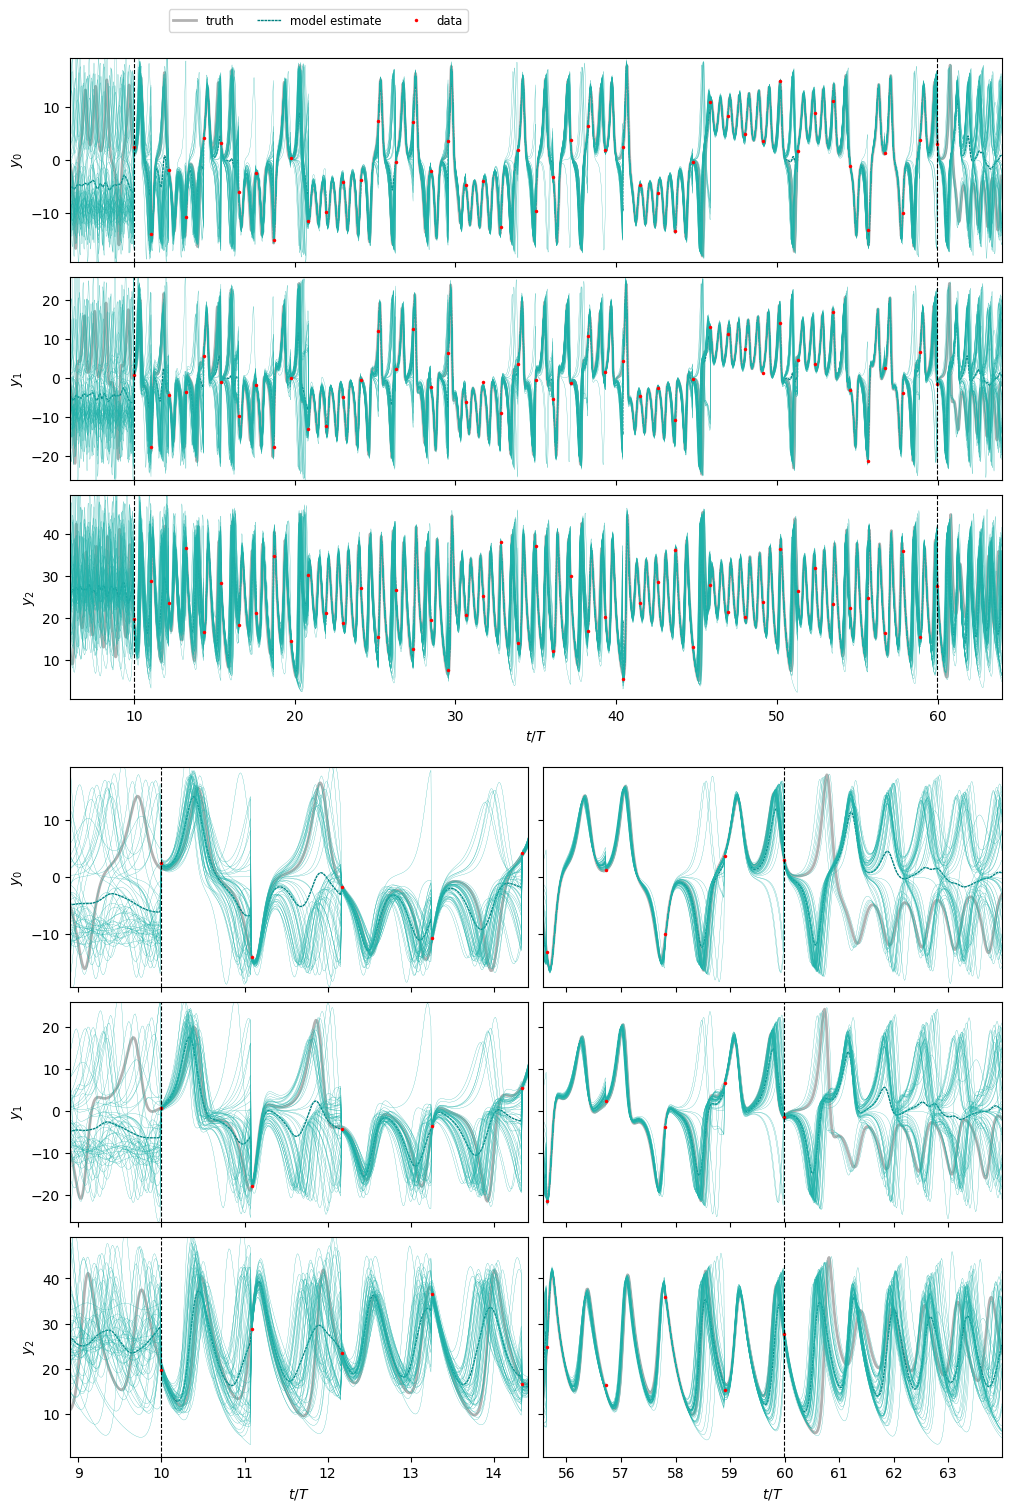

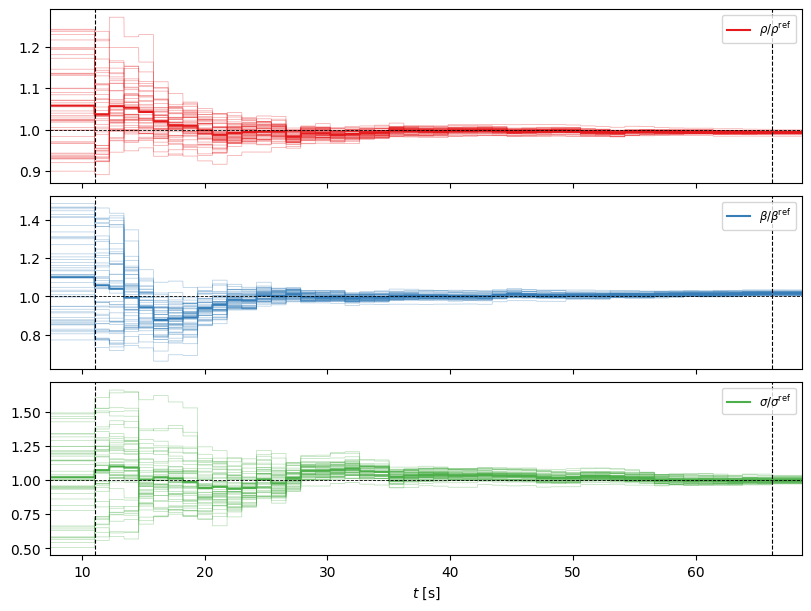

In [18]:
from essentials.plotResults import plot_timeseries, plot_parameters

plot_timeseries(filter_ens, truth, reference_t=t_lyap, plot_ensemble_members=True)
plot_parameters(filter_ens, truth, reference_p=alpha_true)

### Visualize attractors
Time-accurate long term predictions in chaotic systems is not possible due to the exponential divergence (i.e., the butterfly effect). Therefore, learning chaotic dynamics is learning its statistics. 

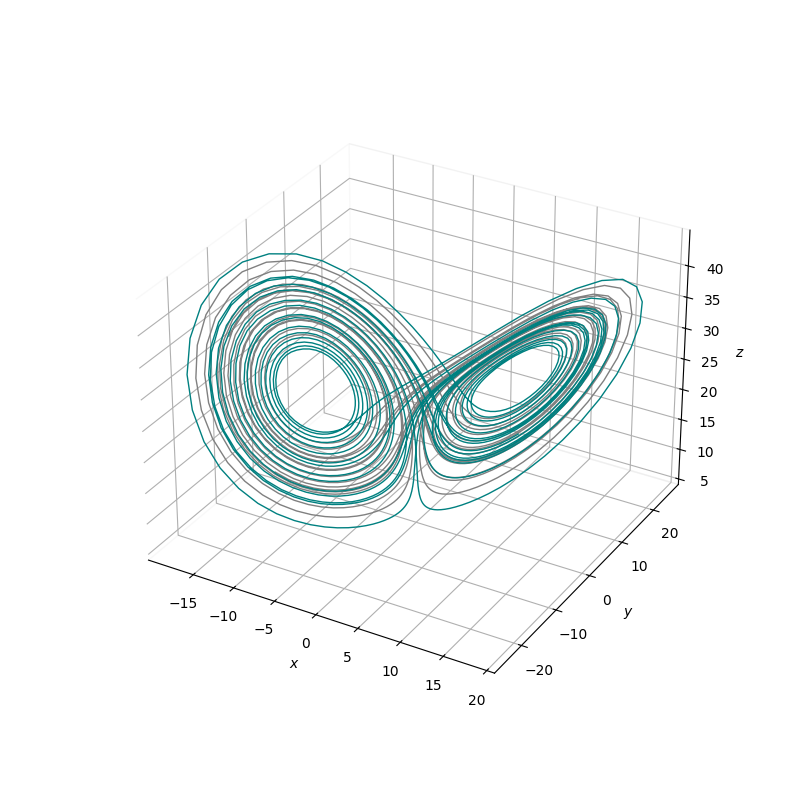

In [23]:

# %matplotlib widget  # Comment out to be able to rotate the 3D plot 

from essentials.plotResults import plot_attractor

case0 = truth['case'].copy()
case1 = filter_ens.copy()

# Forecast both cases
Nt = 20 * int(t_lyap / filter_ens.dt)
psi0, t0 = case0.time_integrate(Nt=Nt)
psi1, t1 = case1.time_integrate(Nt=Nt, averaged=True)

plot_attractor([psi0, psi1], color=['gray', 'teal'])




<br />

___

### Exercise:

<em> <font color=#7CB9E8> -How would you expect the solution to change if we decrease/increase the assimilation frequency? Can the Lyapunov exponent help decide the assimilation frequency?


<em> <font color=#7CB9E8> -How would you expect the solution to change if we observe only part of the state?
</em>


<br />

___
